# Libs and Modules

In [1]:
pip install emoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 9.0 MB/s eta 0:00:00


In [2]:
pip install demoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.6 MB/s eta 0:00:00


In [3]:
#!pip install emoji --upgrade
#26 march latest

In [4]:
import pandas as pd
import numpy as np

import json
import re
import string
import demoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import emoji
from collections import Counter

# File upload and initial dataframes

In [5]:
def load_and_extract_data(file_paths):
    extracted_data_hetero = []
    extracted_data_lgbtq = []

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)

        for entry in data:
            user = entry.get('user', {})
            name = user.get('name', None)
            location = user.get('location', None)
            description = user.get('description', None)
            full_text = entry.get('full_text', None)

            extracted_data = {
                'name': name,
                'location': location,
                'description': description,
                'full_text': full_text
            }

            if 'Heterosexual' in file_path:
                extracted_data_hetero.append(extracted_data)
            else:
                extracted_data_lgbtq.append(extracted_data)

    df_hetero = pd.DataFrame(extracted_data_hetero)
    df_lgbtq = pd.DataFrame(extracted_data_lgbtq)


    return df_hetero, df_lgbtq

file_paths = ['/content/Heterosexual.json', '/content/LGBTQ.json']
df_hetero, df_lgbtq = load_and_extract_data(file_paths)

In [6]:
print(df_hetero.shape)
print(df_lgbtq.shape)


(2322, 4)
(2559, 4)


In [7]:
df_hetero.head()

,name,location,description,full_text
0,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,I once applied for a job in 2020.\n\nI was inv...
1,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Let's talk about the impact of PBs on brain de...
2,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Y’all need to see this 🤣 https://t.co/bC4nKKiaG9
3,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Hi X\n\nThis is my 22 year old bedbound daught...
4,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Who is he?\nPls get every details about him. S...


In [8]:
unique_descriptions = df_hetero['name'].unique()
print(len(unique_descriptions))

25


In [9]:
unique_descriptions = df_lgbtq['name'].unique()
print(len(unique_descriptions))

29


# Preprocess & EDA

Given the raw input Tweets, to obtain the same pre-processing output, users could employ our TweetNormalizer module.

Installation: pip3 install nltk emoji==0.6.0
The emoji version must be either 0.5.4 or 0.6.0. Newer emoji versions have been updated to newer versions of the Emoji Charts, thus not consistent with the one used for pre-processing our pre-training Tweet corpus.

To identify English Tweets,
we employ the language identification component of fastText (Joulin et al., 2017). We tokenize those English Tweets using “TweetTokenizer” from the NLTK toolkit (Bird et al.,
2009) and use the emoji package to translate
emotion icons into text strings (here, each icon
is referred to as a word token).

We also normalize the Tweets by converting user mentions and
web/url links into special tokens @USER and
HTTPURL, respectively. We filter out retweeted
Tweets and the ones shorter than 10 or longer
than 64 word tokens.

We use a “soft” normalization strategy to all of
the experimental datasets by translating word tokens of user mentions and web/url links into special tokens @USER and HTTPURL, respectively,
and converting emotion icon tokens into corresponding strings

## Remove Links

Removed example: Look the white.head() last row

In [10]:
def process_dataframe(df):
    def remove_http_urls(text):
        if isinstance(text, str):
            return re.sub(r'https?://\S*', '', text)
        return text

    df_processed = df.copy()
    df_processed['full_text_processed'] = df_processed['full_text'].apply(remove_http_urls)
    df_processed.drop(columns=['full_text'], inplace=True)
    return df_processed

In [11]:
df_prep_hetero = process_dataframe(df_hetero)
df_prep_lgbtq = process_dataframe(df_lgbtq)


df_prep_hetero.head()


,name,location,description,full_text_processed
0,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,I once applied for a job in 2020.\n\nI was inv...
1,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Let's talk about the impact of PBs on brain de...
2,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Y’all need to see this 🤣
3,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Hi X\n\nThis is my 22 year old bedbound daught...
4,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Who is he?\nPls get every details about him. S...


## Used Hashtags

In [12]:
def extract_and_flatten_hashtags(df):
    hashtags = df['full_text_processed'].str.findall(r'#\w+')
    flat_hashtags = [tag.lower() for sublist in hashtags if sublist is not None for tag in sublist]
    return flat_hashtags

flat_hashtags_hetero = extract_and_flatten_hashtags(df_prep_hetero)
flat_hashtags_lgbtq = extract_and_flatten_hashtags(df_prep_lgbtq)

print('Heterosexual hashtags: ',flat_hashtags_hetero)
print('LGBTQ hashtags: ',flat_hashtags_lgbtq)


Heterosexual hashtags:  ['#whiterose', '#londonbridgeisfallingdown', '#mridulgate', '#mridulwadhwa', '#mridulmustgo', '#maggiechapmanmustgo', '#boycottjohnlewis', '#boycottwaitrose', '#ripjohnlewis', '#inclusivity', '#biblestudyonspace', '#whiterose', '#nomancanbreastfeed', '#mridulmustgo', '#whiterose', '#transwomenareconmen', '#boycottjohnlewis', '#boycottwaitrose', '#boycottjohnlewis', '#boycottwaitrose', '#sacksharon', '#mridulmustgo', '#pubertyisahumanright', '#mridulmustgo', '#boycottjohnlewis', '#boycottwaitrose', '#leavethekidsalone', '#leaveourkidsalone', '#whiterose', '#newauthor', '#greatstory', '#youshouldread', '#readerscommunity', '#readersoftwitter', '#readers', '#readingcommunity', '#readingforpleasure', '#readon', '#dogsatpollingstations', '#biologymatters', '#pmqs', '#trumpmugshot', '#bbclaurak', '#bbcqt', '#bbcqt', '#sexmatters', '#danwoottonexposed', '#witchhunt', '#disgusting', '#misogyny', '#bbcqt', '#bbclaurak', '#transsexualhealth', '#bbcqt', '#ratelimitexceeded

In [13]:
def count_and_print_hashtags(hashtags_list, top_n=10):
    list_name = [name for name, var in globals().items() if var is hashtags_list][0]
    lowercase_hashtags = [tag.lower() for tag in hashtags_list]

    hashtag_counts = {}
    for tag in lowercase_hashtags:
        if tag in hashtag_counts:
            hashtag_counts[tag] += 1
        else:
            hashtag_counts[tag] = 1

    sorted_hashtag_counts = dict(sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True))

    print(f"List name: {list_name}")


    top_hashtags = []
    for i, (tag, count) in enumerate(sorted_hashtag_counts.items()):
        if i >= top_n:
            break
        print(f"{tag}: {count}")
        top_hashtags.append(tag)

    return '####################################'

In [14]:
print(count_and_print_hashtags(flat_hashtags_hetero,10))
print(count_and_print_hashtags(flat_hashtags_lgbtq,10))


List name: flat_hashtags_hetero
#gaza: 29
#txlege: 14
#covid19: 14
#bbcqt: 10
#vaccine: 8
#gazagenocide: 7
#gaza_genocide: 7
#wethepeople: 7
#israel: 5
#wef: 5
####################################
List name: flat_hashtags_lgbtq
#lgbtq: 25
#trans: 21
#lgbt: 15
#pridemonth: 12
#posefx: 12
#jkrvslgbtq: 11
#holdmecloser: 10
#dragrace: 10
#actuallyautistic: 9
#rocketman: 7
####################################


In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def remove_hashtags(hashtags_list):
    for i in range(len(hashtags_list)):
        hashtags_list[i] = hashtags_list[i].replace('#', '')

def create_wordcloud(hashtags_list):
    remove_hashtags(hashtags_list)
    text = ' '.join(hashtags_list).lower()
    if text:
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=None,
                              min_font_size=10).generate(text)
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()
    else:
        print("No words found for generating a word cloud.")

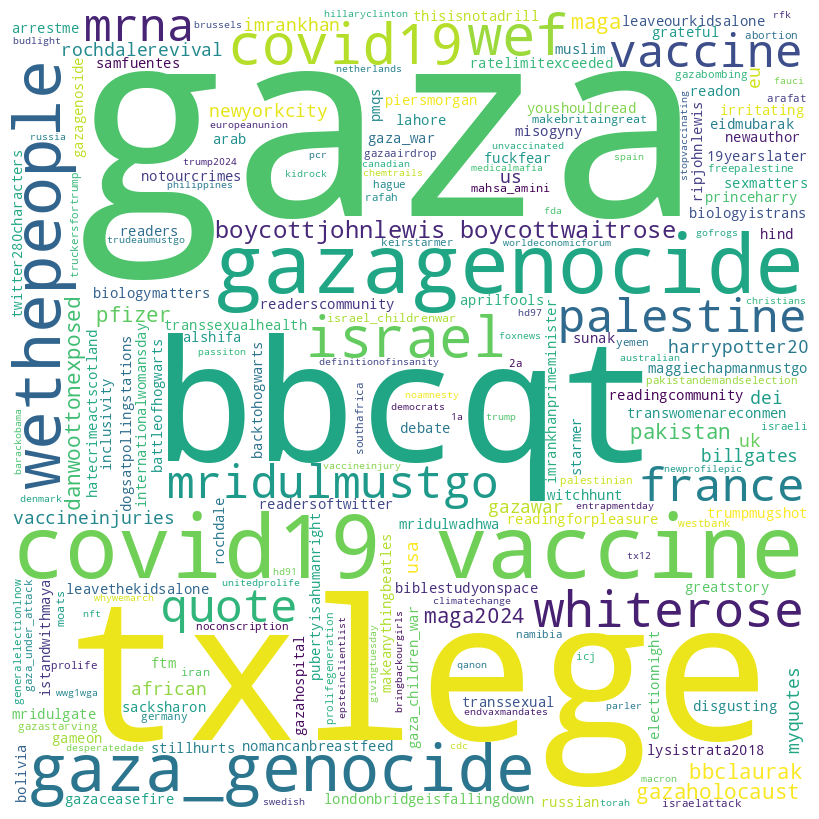

In [16]:
create_wordcloud(flat_hashtags_hetero)

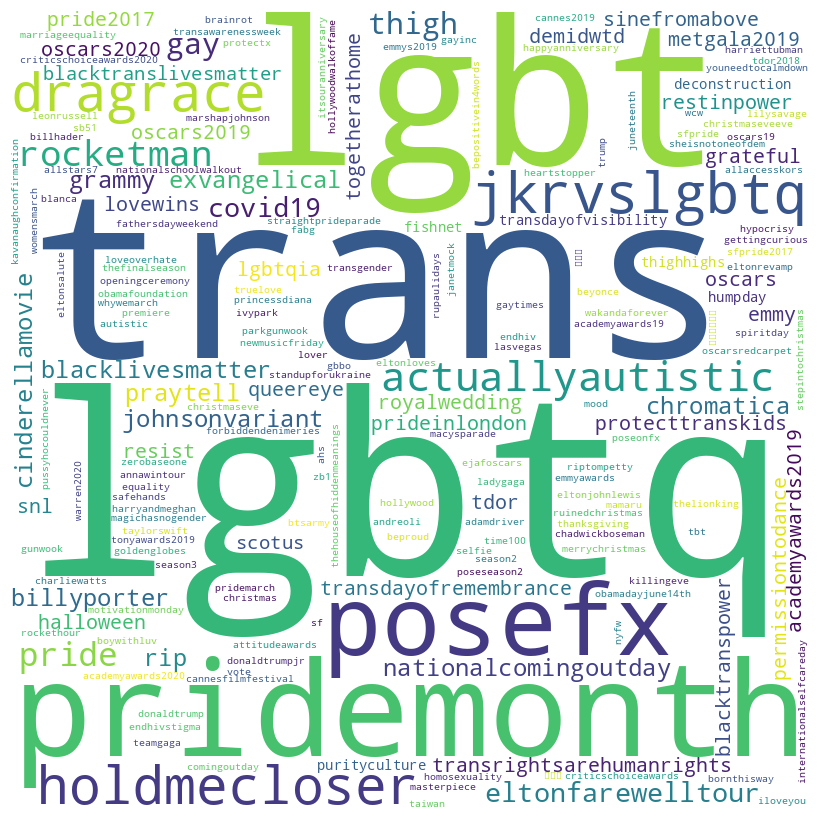

In [17]:
create_wordcloud(flat_hashtags_lgbtq)

## Used Emoji

In [18]:
def extract_emojis(text):
    if text is None:
        return ''
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

def process_emojis(df):
    df_emojis = pd.DataFrame()
    for column in df.columns:
        df_emojis[column + '_emojis'] = df[column].apply(extract_emojis)

    all_emojis = ''.join(row for row in df_emojis.apply(lambda x: ''.join(x), axis=1))
    emoji_counts = Counter(all_emojis)
    return emoji_counts

emoji_counts_hetero = process_emojis(df_hetero)
print('Heterosexual Emoji: ', emoji_counts_hetero)

emoji_counts_lgbtq = process_emojis(df_lgbtq)
print('LGBTQ Emoji: ', emoji_counts_lgbtq)



Heterosexual Emoji:  Counter({'❤': 685, '🐝': 203, '💯': 202, '▪': 166, '‼': 111, '✨': 102, '®': 101, '💍': 100, '🖕': 100, '🦕': 98, '💚': 98, '💜': 98, '🤍': 98, '✝': 98, '👨': 97, '👩': 97, '👧': 97, '👦': 97, '😂': 85, '🔥': 61, '💕': 42, '🤣': 41, '✅': 36, '🦗': 29, '🙏': 27, '♂': 27, '🔴': 25, '🤡': 24, '😭': 21, '⭐': 21, '😡': 19, '🤔': 19, '🚨': 16, '👏': 16, '👇': 15, '🤷': 15, '🙄': 14, '🥰': 13, '🏼': 11, '😊': 11, '🍀': 10, '💔': 8, '😎': 8, '🌿': 8, '◼': 8, '🙌': 7, '♥': 7, '🙇': 5, '👌': 5, '🤦': 5, '💩': 5, '🥲': 4, '😉': 4, '👀': 4, '🎉': 4, '🎶': 4, '🌎': 4, '🍃': 4, '🥁': 4, '💥': 4, '🙋': 4, '😍': 3, '💪': 3, '💉': 3, '😜': 3, '🤪': 3, '⬇': 3, '😩': 3, '😢': 2, '🥂': 2, '🚀': 2, '💫': 2, '🍿': 2, '🏴': 2, '♀': 2, '🗞': 2, '😘': 2, '⚡': 2, '💐': 2, '🌼': 2, '🌸': 2, '🌹': 2, '😳': 2, '🏾': 2, '🍊': 2, '👍': 2, '⁉': 2, '🔹': 2, '🧃': 2, '👁': 2, '🏻': 2, '💧': 2, '😪': 1, '☺': 1, '😁': 1, '📌': 1, '😃': 1, '🥇': 1, '👑': 1, '☘': 1, '📸': 1, '🏡': 1, '🃏': 1, '🤞': 1, '🥊': 1, '🦴': 1, '🥩': 1, '🍍': 1, '🎧': 1, '🤬': 1, '🥬': 1, '🤗': 1, '👢': 1, '💿': 1, '📣': 1, 

### If you want to see the emojis inside the dataframe of that race.


In [19]:
df_emojis_hetero = pd.DataFrame()
for column in df_hetero.columns:
    df_emojis_hetero[column + '_emojis'] = df_hetero[column].apply(extract_emojis)
df_emojis_hetero.head(10)

,name_emojis,location_emojis,description_emojis,full_text_emojis
0,,,,
1,,,🦕💚💜🤍,
2,,,,🤣
3,,,🦕💚💜🤍,
4,,,,😪
5,,,🦕💚💜🤍,
6,,,,🥲❤
7,,,🦕💚💜🤍,
8,,,,🙏😭
9,,,🦕💚💜🤍,


### Count of spesific emoji

In [20]:
specific_emoji = "🏴"
emoji_count = emoji_counts_hetero.get(specific_emoji, 0)
print(f"Count of {specific_emoji}: {emoji_count}")

Count of 🏴: 2


## Removing emojis or encoding

In [21]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)

In [22]:
def preprocess_text(text):
    if text is None:
        return ''

    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    def replace_emoji(match):
        return " " + emoji.demojize(match.group(0)).replace(':', '') + " "

    text = re.sub(emoji_pattern, replace_emoji, text)
    text = ' '.join(text.split())
    return text

In [23]:
df_prep_lgbtq['cleaned_text'] = df_prep_lgbtq['full_text_processed'].apply(preprocess_text)
df_prep_hetero['cleaned_text'] = df_prep_hetero['full_text_processed'].apply(preprocess_text)



## Replace \\n with whitespace

In [24]:
def remove_newlines(df, column_name):
    df[column_name] = df[column_name].str.replace('\n', ' ')
    return df

df_prep_hetero = remove_newlines(df_prep_hetero, 'cleaned_text')
df_prep_lgbtq = remove_newlines(df_prep_lgbtq, 'cleaned_text')


## Deleting extra whitespaces

In [25]:
def replace_multiple_spaces(df, column_name):
    df[column_name] = df[column_name].str.replace(r'\s+', ' ')
    return df

# Example usage
df_prep_hetero = replace_multiple_spaces(df_prep_hetero, 'cleaned_text')
df_prep_lgbtq = replace_multiple_spaces(df_prep_lgbtq, 'cleaned_text')


df_prep_hetero.head()

,name,location,description,full_text_processed,cleaned_text
0,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,I once applied for a job in 2020.\n\nI was inv...,i once applied for a job in 2020 i was invited...
1,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Let's talk about the impact of PBs on brain de...,lets talk about the impact of pbs on brain dev...
2,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Y’all need to see this 🤣,y’all need to see this rolling_on_the_floor_la...
3,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Hi X\n\nThis is my 22 year old bedbound daught...,hi x this is my 22 year old bedbound daughter ...
4,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Who is he?\nPls get every details about him. S...,who is he pls get every details about him some...


## Replace undurscore with whitespace

In [26]:
def remove_newlines(df, column_name):
    df[column_name] = df[column_name].str.replace('_', ' ')
    return df

df_prep_hetero = remove_newlines(df_prep_hetero, 'cleaned_text')
df_prep_lgbtq = remove_newlines(df_prep_lgbtq, 'cleaned_text')


In [27]:
df_prep_hetero.head()

,name,location,description,full_text_processed,cleaned_text
0,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,I once applied for a job in 2020.\n\nI was inv...,i once applied for a job in 2020 i was invited...
1,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Let's talk about the impact of PBs on brain de...,lets talk about the impact of pbs on brain dev...
2,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Y’all need to see this 🤣,y’all need to see this rolling on the floor la...
3,Dr P,,TERF/GC ULTRA 30-year qualified DClinPych C.Ps...,Hi X\n\nThis is my 22 year old bedbound daught...,hi x this is my 22 year old bedbound daughter ...
4,DON “Tobechukwu” Ade,The Secret Place,Your Brother in Christ || Pharmacist || Data S...,Who is he?\nPls get every details about him. S...,who is he pls get every details about him some...


## Showing rows with less than 3 characters

In [28]:
print(df_prep_hetero.shape)
print(df_prep_lgbtq.shape)

(2322, 5)
(2559, 5)


In [29]:
def filter_dataframe(df):
    filtered_df = df[df['cleaned_text'].str.len() < 3]
    df = df.drop(filtered_df.index)
    return df

df_prep_hetero = filter_dataframe(df_prep_hetero)
df_prep_lgbtq = filter_dataframe(df_prep_lgbtq)


In [30]:
print(df_prep_hetero.shape)
print(df_prep_lgbtq.shape)

(2201, 5)
(2545, 5)


# Merge dataframes

In [31]:
df_prep_hetero['orientation'] = 'hetero'
df_prep_lgbtq['orientation'] = 'lgbtq'


In [32]:
print(df_prep_hetero.shape)
print(df_prep_lgbtq.shape)


(2201, 6)
(2545, 6)


In [33]:
df_merged = pd.concat([df_prep_hetero, df_prep_lgbtq], ignore_index=True)
columns_to_drop = ['name', 'location', 'description','full_text_processed']
df_merged = df_merged.drop(columns=columns_to_drop)
print(df_merged.shape)
df_merged.head()

(4746, 2)


,cleaned_text,orientation
0,i once applied for a job in 2020 i was invited...,hetero
1,lets talk about the impact of pbs on brain dev...,hetero
2,y’all need to see this rolling on the floor la...,hetero
3,hi x this is my 22 year old bedbound daughter ...,hetero
4,who is he pls get every details about him some...,hetero


# Advanced Methods for predicttion

efore applying BPE to the pre-training corpus of English Tweets, we tokenized these Tweets using TweetTokenizer from the NLTK toolkit and used the emoji package to translate emotion icons into text strings (here, each icon is referred to as a word token). We also normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL, respectively. Thus it is recommended to also apply the same pre-processing step for BERTweet-based downstream applications w.r.t. the raw input Tweets.

Given the raw input Tweets, to obtain the same pre-processing output, users could employ our TweetNormalizer module.

Installation: pip3 install nltk emoji==0.6.0
The emoji version must be either 0.5.4 or 0.6.0. Newer emoji versions have been updated to newer versions of the Emoji Charts, thus not consistent with the one used for pre-processing our pre-training Tweet corpus.

from TweetNormalizer import normalizeTweet


In [34]:
print(df_merged.isnull().sum())

cleaned_text    0
orientation     0
dtype: int64


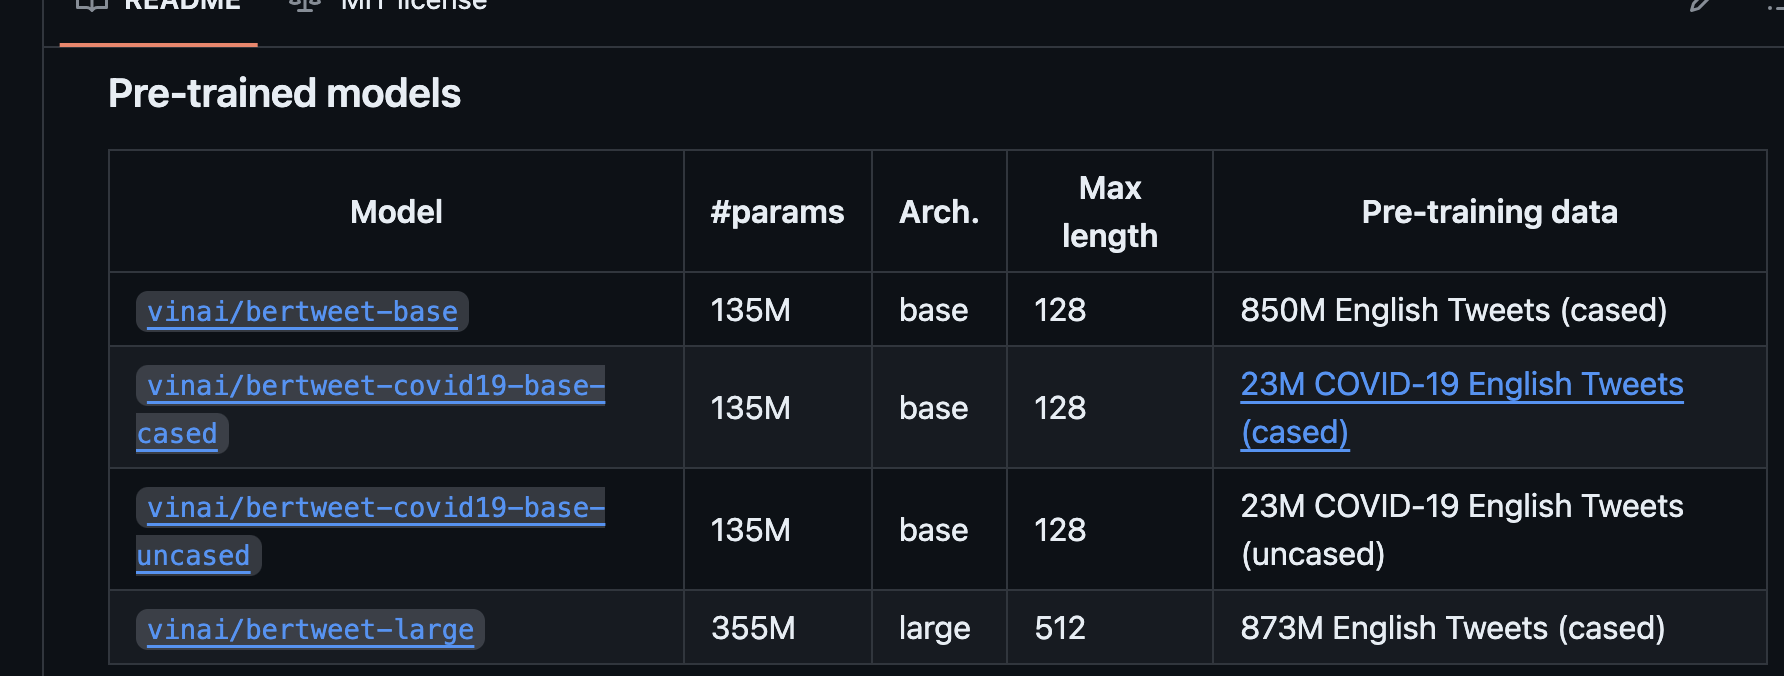

Install transformers with pip: pip install transformers, or install transformers from source.
Note that we merged a slow tokenizer for BERTweet into the main transformers branch. The process of merging a fast tokenizer for BERTweet is in the discussion, as mentioned in this pull request. If users would like to utilize the fast tokenizer, the users might install transformers as follows:
git clone --single-branch --branch fast_tokenizers_BARTpho_PhoBERT_BERTweet https://github.com/datquocnguyen/transformers.git
cd transformers
pip3 install -e .

In [35]:
!pip install transformers
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split

In [36]:
model = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

We employ the transformers library (Wolf
et al., 2019) to independently fine-tune BERTweet
for each task and each dataset in 30 training
epochs. We use AdamW (Loshchilov and Hutter, 2019) with a fixed learning rate of 1.e-5 and
a batch size of 32 (Liu et al., 2019). We compute
the task performance after each training epoch on
the validation set (here, we apply early stopping
when no improvement is observed after 5 continuous epochs)

each pre-trained language model the “soft” scores
are generally higher than the corresponding “hard”
scores, i.e. applying lexical normalization dictionaries to normalize word tokens in Tweets generally does not help improve the performance of the
pre-trained language models on downstream tasks

In [37]:
#dataset object that can be passed to a PyTorch DataLoader for batching and iterating over
#handles the tokenization and encoding of text inputs using the provided tokenizer
class CustomDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]) #ensure that the text is in a format that can be processed by the tokenizer.
        target = self.targets[idx]
        try:
            encoding = self.tokenizer.encode_plus(
            text, #This is the input text that we want to encode.
            add_special_tokens=True, #This parameter specifies that special tokens like [CLS] (start of sequence) and [SEP] (end of sequence) should be added to the input text. These tokens are required for RoBERTa.
            max_length=self.max_len, #f the input text is longer than this length, it will be truncated. If it is shorter, it will be padded.
            return_token_type_ids=None,  # DIfferent than bert, Make sure no token type IDs are returned as they are not required for RoBERTa
            padding='max_length',
            truncation=True,
            return_attention_mask=True,#The attention mask is a binary mask indicating which tokens are actual words and which are padding tokens.
            return_tensors='pt' #specifies that the output should be returned as PyTorch tensors ('pt').
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),#token IDs of the input text.
                'attention_mask': encoding['attention_mask'].flatten(),# which indicates which tokens are real words and which are padding tokens.
                'targets': torch.tensor(target, dtype=torch.long) #integer
            }
        except KeyError as e:
            print(f"Index Error: {idx} not found.")
            raise


In [38]:
print(df_merged['orientation'].unique())
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_merged['orientation'] = le.fit_transform(df_merged['orientation'])

print(df_merged['orientation'].unique())

['hetero' 'lgbtq']
[0 1]


In [39]:
from torch.nn.utils.rnn import pad_sequence
#combine a batch of samples into a single batch
def custom_collate_fn(batch):
  input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True) #pad the sequences to the same length.
  attention_masks = pad_sequence([item['attention_mask'] for item in batch], batch_first=True)#same as above but for the 'attention_mask'.
  targets = torch.stack([item['targets'] for item in batch]) #extracts the 'targets' from each item in the batch and then stacks them into a single tensor
  return {'input_ids': input_ids, 'attention_mask': attention_masks, 'targets': targets} #eturns a dictionary containing the padded input IDs, attention masks, and targets as a single batch

In [40]:
train_size = 0.8
test_and_val_size = 0.2
test_size = 0.5

df_train, df_test_val = train_test_split(df_merged, test_size=test_and_val_size, random_state=42)
df_val, df_test = train_test_split(df_test_val, test_size=test_size, random_state=42)


#80-10-10


df_train = df_train.reset_index(drop=True)#reset the index of a DataFrame, drop the old index and replace it with a new sequential index
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

BATCH_SIZE = 16
MAX_LEN = 100  # 128

train_data = CustomDataset(df_train['cleaned_text'], df_train['orientation'], tokenizer, MAX_LEN)
val_data = CustomDataset(df_val['cleaned_text'], df_val['orientation'], tokenizer, MAX_LEN)
test_data = CustomDataset(df_test['cleaned_text'], df_test['orientation'], tokenizer, MAX_LEN)

#data loader batching automatically batches the data, which means it combines individual samples into batches
#GPUs can process batches of data faster than individual samples.
#shuffle for ensure that the model doesn't learn the order of the data
#DataLoader takes care of loading the data in parallel,
#collate_fn for if samples have different sizes or structures.
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

In [41]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [42]:
from torch import nn
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

with torch.no_grad():
    features = bertweet(input_ids)  # Models outputs are now tuples


https://github.com/VinAIResearch/BERTweet/blob/e36876c673438159de0233e9b1e9eee61d8902b3/README.md?plain=1#L78

In [43]:
EPOCHS = 100

In [44]:
class RaceClassifier(nn.Module):

    def __init__(self, n_classes):
        super(RaceClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")
        self.drop = nn.Dropout(p=0.3) #can be changed in future
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) #linear layer for the output with the number of classes

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        last_hidden_state = bert_output[0]
        pooled_output = last_hidden_state[:, 0]
        output = self.drop(pooled_output)
        return self.out(output)

n_classes = len(df_merged['orientation'].unique()) #4 races
model = RaceClassifier(n_classes)
model = model.to(device) #passed to gpu


#higher weights to the minority class
class_weights = compute_class_weight('balanced', classes=np.unique(df_train.orientation), y=df_train.orientation) #computed based on the class distribution in the training dataset
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)#measures the performance of a classification model whose output is a probability value between 0 and 1
optimizer = Adam(model.parameters(), lr=1e-5) # need  look at the paper for proper param

#will be used by step function
scheduler = get_linear_schedule_with_warmup( #prevent the model from diverging early on.
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_dataloader) * EPOCHS
)

## Result


Epoch: 1/100, Train Loss:  0.574
Train Accuracy: 68.26 %
Validation Loss: 0.416



Epoch: 2/100, Train Loss:  0.384
Train Accuracy: 82.46 %
Validation Loss: 0.329



Epoch: 3/100, Train Loss:  0.256
Train Accuracy: 90.31 %
Validation Loss: 0.338



Epoch: 4/100, Train Loss:  0.165
Train Accuracy: 93.81 %
Validation Loss: 0.388



Epoch: 5/100, Train Loss:  0.114
Train Accuracy: 95.89 %
Validation Loss: 0.402



Epoch: 6/100, Train Loss:  0.095
Train Accuracy: 96.71 %
Validation Loss: 0.394



Epoch: 7/100, Train Loss:  0.063
Train Accuracy: 98.26 %
Validation Loss: 0.551



Epoch: 8/100, Train Loss:  0.054
Train Accuracy: 98.39 %
Validation Loss: 0.466
Early stopping


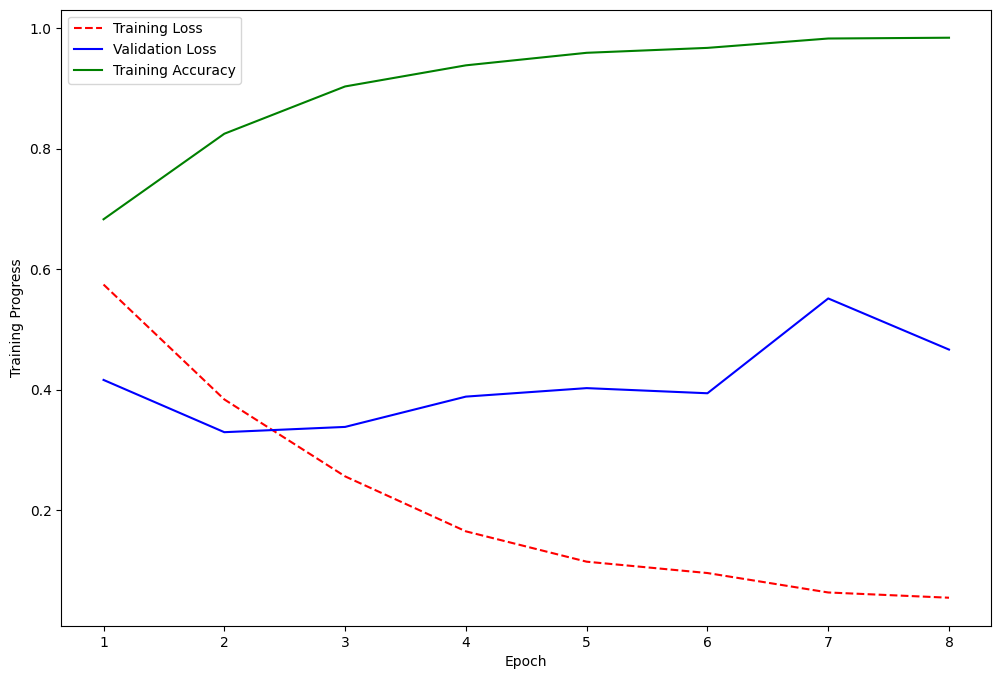

In [45]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

PATIENCE = 5  # number of epochs to wait before stopping, same as the paper berttweet

train_loss_values = []
val_loss_values = []
accuracy_values = []

best_loss = np.inf
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct_predictions = 0
    total = 0

    for _, data in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    average_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total

    train_loss_values.append(average_train_loss)
    accuracy_values.append(train_accuracy)

    print(f'\nEpoch: {epoch+1}/{EPOCHS}, Train Loss:  {average_train_loss:.3f}')
    print('Train Accuracy: {:.2f} %'.format(100 * train_accuracy))

    # Validation
    val_loss = 0
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_dataloader):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['targets'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    average_val_loss = val_loss / len(val_dataloader)
    val_loss_values.append(average_val_loss)
    print(f'Validation Loss: {average_val_loss:.3f}')

    # Check for early stopping
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), 'best_model_orientation.pt')

    else:
        patience_counter += 1

    if patience_counter > PATIENCE:
        print("Early stopping")
        break

epoch_count = range(1, len(train_loss_values) + 1)
model.load_state_dict(torch.load('best_model_orientation.pt'))

plt.figure(figsize=(12, 8))
plt.plot(epoch_count, train_loss_values, 'r--')
plt.plot(epoch_count, val_loss_values, 'b-')
plt.plot(epoch_count, accuracy_values, 'g-')
plt.legend(['Training Loss', 'Validation Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Progress')
plt.show();

## Test with unseen data

### Predicting the labels

In [46]:
model.load_state_dict(torch.load('best_model_orientation.pt', map_location=device))
model.eval()

def text_to_loader(tokenizer, texts, max_len):
    encoding = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    return [{
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
    }]

def predict(model, dataloader):
    model = model.eval()
    predictions = []

    with torch.no_grad():
        for item in dataloader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)

    return [le.inverse_transform([pred.item()])[0] for pred in predictions]  # Invert


In [47]:
unseen_texts = ["I love cooking"] #there are only 2 genders
true_labels = ["lgbtq"]

MAX_LEN = 100
test_dataloader = DataLoader(text_to_loader(tokenizer, unseen_texts, MAX_LEN), batch_size=1)

predictions = predict(model, test_dataloader)

for text, true, pred in zip(unseen_texts, true_labels, predictions):
    print(f'Text: {text}')
    print(f'Predicted: {pred}, Actual: {true}\n')

Text: I love cooking
Predicted: lgbtq, Actual: lgbtq



### Giving probs for labels

In [48]:
def predict_probabilities(model, dataloader):
    model = model.eval()
    all_probs = []

    with torch.no_grad():
        for item in dataloader:
            input_ids = item['input_ids'].to(device)
            attention_mask = item['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs)

    return all_probs


In [49]:
probabilities = predict_probabilities(model, test_dataloader)
unseen_texts = ["i love cooking"]
true_labels = ["lgbtq"]

In [50]:
for text, true, probs in zip(unseen_texts, true_labels, probabilities):
    label_probs = {le.inverse_transform([i])[0]: prob.item() for i, prob in enumerate(probs[0])}
    print(f'Text: {text}')
    print(f'Label Probabilities: {label_probs}, Actual: {true}\n')

Text: i love cooking
Label Probabilities: {'hetero': 0.27171292901039124, 'lgbtq': 0.7282870411872864}, Actual: lgbtq



### Giving multiple sentence

In [51]:
# Sample sentences
sentences = [
#Heterosexual

"I am heterosexual.",
"I am attracted to the opposite gender.",
"I have had romantic relationships with the opposite gender.",
"I am comfortable with my sexual orientation.",
"I support equal rights for heterosexual individuals.",
"I am open about my sexual orientation.",
"I have never questioned my attraction to the opposite gender.",
"I believe in traditional marriage between a man and a woman.",
"I am not part of the LGBTQ+ community.",
"I do not experience same-sex attraction.",
#LGBTQ

"I am LGBTQ+.",
"I am attracted to the same gender.",
"I have had romantic relationships with the same gender.",
"I am comfortable with my sexual orientation/gender identity.",
"I support equal rights for LGBTQ+ individuals.",
"I am open about my sexual orientation/gender identity.",
"I have faced discrimination based on my sexual orientation/gender identity.",
"I am part of the LGBTQ+ community.",
"I have chosen a non-traditional gender identity.",
"I experience same-sex attraction."
]

# Corresponding expected races
expected_races = [
    "hetero", "hetero", "hetero", "hetero", "hetero", "hetero", "hetero", "hetero", "hetero", "hetero",
    "lgbtq", "lgbtq", "lgbtq", "lgbtq", "lgbtq", "lgbtq", "lgbtq", "lgbtq", "lgbtq", "lgbtq"
]

encoded_sentences = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LEN,
)

input_ids = encoded_sentences["input_ids"].to(device)
attention_mask = encoded_sentences["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    predictions = predictions.cpu().numpy()

predicted_labels = le.inverse_transform(predictions)
label_counts = {}
correct_counts = {}

for label in le.classes_:
    label_counts[label] = 0
    correct_counts[label] = 0

for pred, expected in zip(predicted_labels, expected_races):
    label_counts[expected] += 1
    if pred == expected:
        correct_counts[expected] += 1

print("True Prediction Ratios:")
for label in le.classes_:
    correct_predictions = correct_counts[label]
    total_predictions = label_counts[label]
    ratio = correct_predictions / total_predictions * 100 if total_predictions > 0 else 0
    print(f"{label}: {ratio:.2f}% (Total: {total_predictions}, Correct: {correct_predictions})")

print("\nIndividual Predictions:")

for i, (sentence, prediction, expected_race) in enumerate(zip(sentences, predicted_labels, expected_races)):
    print(f"Sentence {i+1}: '{sentence}'")
    print(f"Predicted: {prediction}, Expected: {expected_race}\n")


True Prediction Ratios:
hetero: 40.00% (Total: 10, Correct: 4)
lgbtq: 60.00% (Total: 10, Correct: 6)

Individual Predictions:
Sentence 1: 'I am heterosexual.'
Predicted: hetero, Expected: hetero

Sentence 2: 'I am attracted to the opposite gender.'
Predicted: hetero, Expected: hetero

Sentence 3: 'I have had romantic relationships with the opposite gender.'
Predicted: hetero, Expected: hetero

Sentence 4: 'I am comfortable with my sexual orientation.'
Predicted: lgbtq, Expected: hetero

Sentence 5: 'I support equal rights for heterosexual individuals.'
Predicted: lgbtq, Expected: hetero

Sentence 6: 'I am open about my sexual orientation.'
Predicted: lgbtq, Expected: hetero

Sentence 7: 'I have never questioned my attraction to the opposite gender.'
Predicted: lgbtq, Expected: hetero

Sentence 8: 'I believe in traditional marriage between a man and a woman.'
Predicted: hetero, Expected: hetero

Sentence 9: 'I am not part of the LGBTQ+ community.'
Predicted: lgbtq, Expected: hetero

Sen

In [52]:
sentences = [
	"tbh, i still show up to my home office a few times a week"
	"Memes are modern wisdom literature."
"People who love lists of mistakes are into errataca."
"He’s not really that dumb, right? No person of his reputation could possibly be that dumb. It must all be an act, right? Right? Right???"
]
#use comma for every sentence if you want them used seperately
#https://twitter.com/tunguz Predicted white actual white



encoded_sentences = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LEN,
)

input_ids = encoded_sentences["input_ids"].to(device)
attention_mask = encoded_sentences["attention_mask"].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    predictions = predictions.cpu().numpy()

predicted_labels = le.inverse_transform(predictions)

expected_race = "hetero" ####################################
expected_label = le.transform([expected_race])[0]

for i, prediction in enumerate(predicted_labels):
    actual_class = le.inverse_transform([expected_label])[0] if expected_label in predictions else expected_race
    print(f"Sentence {i+1}: '{sentences[i]}'")
    print(f"Predicted: {prediction}, Expected: {actual_class}\n")

Sentence 1: 'tbh, i still show up to my home office a few times a weekMemes are modern wisdom literature.People who love lists of mistakes are into errataca.He’s not really that dumb, right? No person of his reputation could possibly be that dumb. It must all be an act, right? Right? Right???'
Predicted: hetero, Expected: hetero

